### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Multiple Linear Regression

A statistical technique that uses several explanatory variables to predict the outcome of a response variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response(dependent) variable.

Here our model is:   

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$   
   
In this case, $Y$ is the response variable which depends on the $p$ predictor variables.

$\beta_0$ is the intercept. This can be interpreted as the value of $Y$ when all predictor variables are equal to zero.

$\beta_j$ is the average effect on $Y$ of a one-unit increase in $X_j$.

### Assignment
Build a model to predict employee salaries from different employee characteristics (or features)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
#from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import ResidualsPlot

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
class ErrorCalculator():
    def __init__(self, y_test, Y_predict):
        self.y_test = y_test
        self.Y_predict = Y_predict
    
    def get_residuals(self):
        return self.y_test - self.Y_predict
    
    def get_standardised_residuals(self):
        return self.get_residuals() / self.get_residuals().std()
    
    def get_mse(self):
        return np.square(np.subtract(self.y_test, self.Y_predict)).mean()
    
    def get_rmse(self):
        return np.sqrt(((self.Y_predict - self.y_test) ** 2).mean())
    
    def error_summary(self):
        return pd.DataFrame({"Standardised Residuals Average Mean" : [self.get_standardised_residuals().mean()],
                             "Standardised Residuals Average Min": [self.get_standardised_residuals().min()],
                             "Standardised Residuals Average Max": [self.get_standardised_residuals().max()],
                             "MSE": [self.get_mse()],
                             "RMSE": [self.get_rmse()]},
                             columns= ["Standardised Residuals Average Mean",
                                     "Standardised Residuals Average Min",
                                     "Standardised Residuals Average Max",
                                     "MSE",
                                     "RMSE"])

class Plotter():
    def __init__(self,y_test,ypred):
        self.y_test = y_test
        self.ypred = ypred
    
    def run_calculations(self):
        return self.y_test - self.ypred
    
    def plot(self):
        plt.hist(self.y_test - self.ypred)
        plt.title('Residuals Plot for predictions')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        return plt.show()   
    
class HistogramPlotter(Plotter):
    def __init__(self, y_test,ypred):
        Plotter.__init__(self, y_test, ypred)
        
class ScatterPlotter(Plotter):
    def __init__(self, y_test, ypred):
        Plotter.__init__(self, y_test, ypred)

    def plot(self):
        chart = pd.DataFrame({"y_test": self.y_test, "y_prediction": self.ypred})
        chart.plot.scatter(x="y_test", y="y_prediction", c="DarkBlue")
        plt.title("Prediction vs Actual values")
        plt.xlabel("Actual")
        plt.ylabel("Prediction")
        return plt.show()

In [3]:
salary = pd.read_csv('../data/salary.csv')
salary = salary.dropna()
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


1. Split your data into a training and test set. Create scatterplots, histograms, and a descriptive statistics table of the variables of interest. Do any of the variables need to be transformed to be able to use them in a linear regression model? Which variables seem like good predictors of salary?

In [4]:
#Describing the numerical features.
salary[['salary','yearsworked','yearsrank','market','exprior','yearsabs']].describe()

,salary,yearsworked,yearsrank,market,exprior,yearsabs
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,50863.220098,12.836257,7.046784,0.948558,2.931774,6.994152
std,12685.132358,9.447040,6.419708,0.149524,4.794327,16.887552
min,29000.000000,0.000000,0.000000,0.710000,0.000000,0.000000
25%,40000.000000,4.000000,2.000000,0.840000,0.000000,0.000000
50%,50096.000000,12.000000,5.000000,0.920000,1.000000,1.000000
75%,60345.000000,22.000000,12.000000,1.020000,4.000000,2.000000
max,96156.000000,41.000000,28.000000,1.330000,25.000000,118.000000


In [5]:
# getting feature correlation
correlation = salary.corr()[abs(salary.corr()["salary"]) > 0.45].sort_values(by=["salary"], ascending=False)

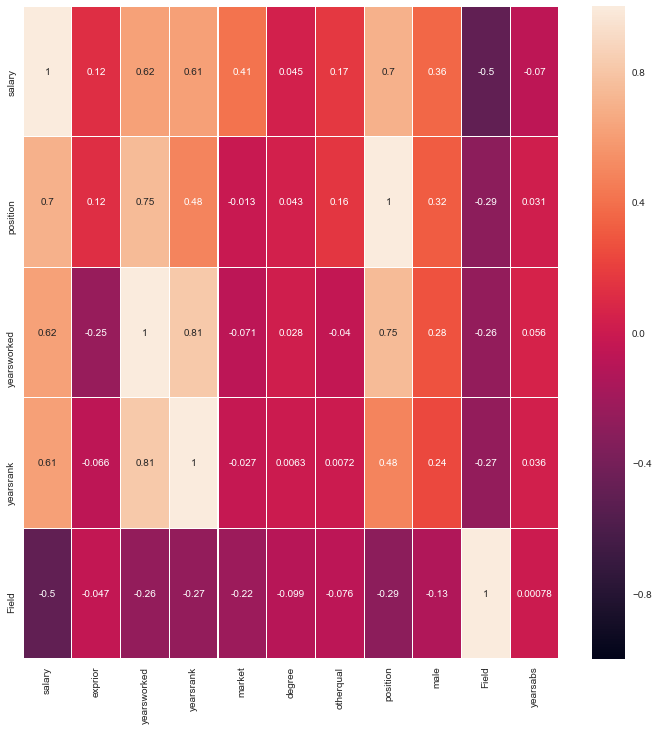

In [6]:
# correlation heatmap
plt.figure(figsize=(12,12))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, linewidth=0.1)


### Hypothesis Testing

Null Hypothesis: There is no relationship that exists between salary and all the features in the dataset.


Alternate Hypothesis: There exists a linear relationship between salary and some of the features in the dataset.

We are testing to validate if there is a relationship that exists between salary and years worked, with a significance level of 5%.

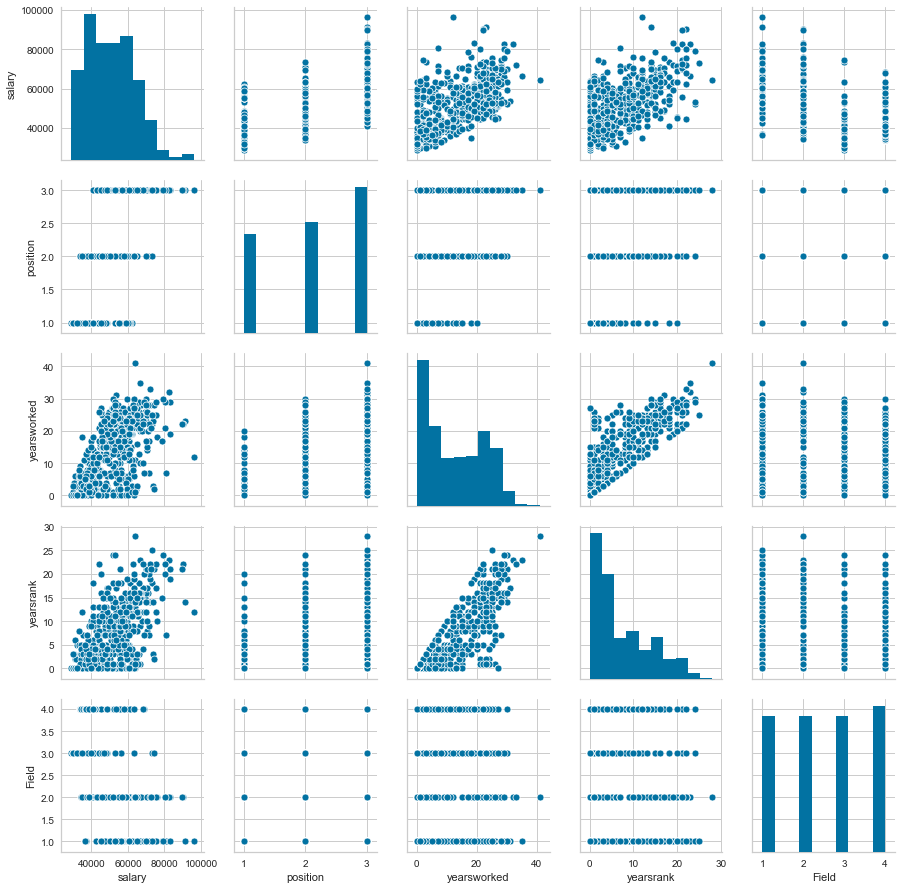

In [7]:
#Scatter and histogram
sns.pairplot(salary[['salary', 'position','yearsworked','yearsrank','Field']])

- Having observed the above charts, for Years Worked and Years Rank we reject the null hypothesis reason being that there is a linear relationship between these variables. There we are selecting these variables as our predictors for the target salary.


- +0.50. A moderate uphill (positive) relationship+0.70. A strong uphill (positive) linear relationship.

2. One-hot encode the variable Field into three dummy variables, using HR as the reference category. You can use pandas’ get_dummies() function for this.

In [8]:
field = pd.get_dummies(salary['Field'])
field.drop(1, inplace=True, axis=1)

new_field = field.rename(columns={2:'Finance',3:'HR',4:'Marketing'})

salary= pd.concat([salary, new_field] ,axis=1, ignore_index=False)
salary.drop("Field", inplace=True, axis=1)
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,53000.0,0,0,0,1.17,1,0,1,1,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,1,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,1,2,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,1,1,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,1,1,0,0,1


#### Feature Transformation

In [9]:
total_variance = []
for i in salary.columns:
    total_variance.append(salary[i].var())

print("Overall variance: {}".format(sum(total_variance) / len(total_variance)))

Overall variance: 12377924.853694368


Due to the high total variance, features will be transformed to reduce the overall variance.

In [10]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(salary)

scaled_data = pd.DataFrame(scaled_data, columns=salary.columns)

scaled_data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,0.168612,-0.612106,-1.360086,-1.098751,1.482433,0.190693,-0.216654,-1.38017,0.5766,-0.414564,-0.570597,1.752549,-0.597614
1,0.563159,-0.403322,-1.360086,-1.098751,1.951044,0.190693,-0.216654,-1.38017,0.5766,-0.414564,1.752549,-0.570597,-0.597614
2,-0.423208,-0.612106,-1.360086,-1.098751,1.750211,0.190693,-0.216654,-1.38017,0.5766,-0.296018,-0.570597,1.752549,-0.597614
3,-1.190050,-0.612106,-1.148173,-0.942829,0.277434,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320
4,-1.272984,-0.612106,-1.148173,-0.786906,-0.258121,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320


In [11]:
scaled_variance = []
for i in scaled_data.columns:
    total_variance.append(scaled_data[i].var())

print("Overall variance: {}".format(sum(scaled_variance)))

Overall variance: 0


4. Use multiple linear regression to predict salary from all the variables in the training dataset. Interpret the standardised coefficients given in the statsmodels output. What are the most important features when predicting employee salary?

In [12]:
from statsmodels.formula.api import ols

X_train, X_test, y_train, y_test = train_test_split(
   scaled_data.drop(labels=["salary"], axis=1),
    scaled_data["salary"],
    test_size = 0.3,
    random_state = 42
)

X_train.shape, X_test.shape

((359, 12), (154, 12))

In [13]:
X = sm.add_constant(X_train[['yearsworked', 'yearsrank']])
model = sm.OLS(y_train, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     148.7
Date:                Sat, 22 Feb 2020   Prob (F-statistic):           1.11e-47
Time:                        16:27:04   Log-Likelihood:                -401.65
No. Observations:                 359   AIC:                             809.3
Df Residuals:                     356   BIC:                             821.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0292      0.039      0.742      0.458      -0.048       0.106
yearsworked     0.3823      0.066      5.750      0.000       0.252       0.513
yearsrank       0.3238      0.065      4.961      0.000       0.195       0.452
==============================================================================
Omnibus:                       27.853   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.120
Skew:                           0.717   Prob(JB):                     1.06e-07
Kurtosis:                       3.299   Cond. No.                         3.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5. Calculate the standardised residuals (resid()) and standardised predicted values (fittedvalues()).

In [14]:
# Calculations for Standard Residuals.
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance
standardized_residuals = influence.resid_studentized_internal
studentized_residuals = influence.resid_studentized_external
studentized_residuals = pd.DataFrame(studentized_residuals)

In [15]:
# Calculations for Fitted Values.
fitted = model.fittedvalues
fitted = pd.DataFrame(fitted)

6. Plot the residuals versus the predicted values using seaborn’s residplot with fitted values as the x parameter, and the dependent variable as y, specify lowess=True. Are there any problems with the regression?


Text(0.5, 0, 'Residuals')

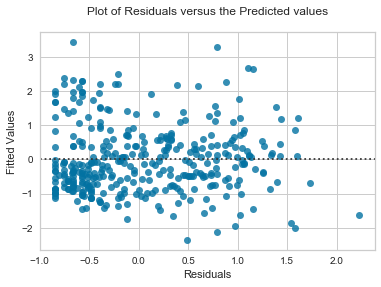

In [16]:
sns.residplot(fitted,studentized_residuals)
plt.title('Plot of Residuals versus the Predicted values\n')
plt.ylabel('Fitted Values')
plt.xlabel('Residuals')

7. Now run your model on the test set. How does your model compare when running it on the test set - what is the difference in the Root Mean Square Error (RMSE) between the training and test sets? Is there any indication that the model has been overfit or does it seem like a reasonably good model?

In [17]:
x_test = sm.add_constant(X_test[['yearsworked','yearsrank']])

y_prediction = model.predict(x_test)

In [18]:
# Train

pred = model.predict(X)

from statsmodels.tools.eval_measures import rmse
training_rmse = rmse(y_train, pred)
training_rmse

0.7407264919933382

In [19]:
# Test
from statsmodels.tools.eval_measures import rmse
testing_rmse = rmse(y_test, y_prediction)
testing_rmse

0.8100651995400382

In [20]:
# diff
training_rmse - testing_rmse

-0.06933870754670002

The testing set performed better than the training set, this does not necessarily
mean the model overfitted the training set. One reason we believe the testing set 
performed so well is the fact that the testing set is relatively smaller than the training
set and or the test set could be fundamentally easier to predict (have less noise, less variance be less influenced by something not captured by the model.

### Conclusion

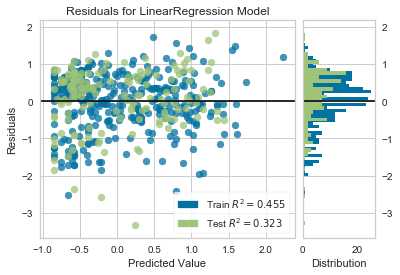

In [21]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot


# Instantiate the linear model and visualizer
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## OOP FOR DATA SCIENCE

### Building Model1

In [22]:
# View of the dataset
scaled_data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,0.168612,-0.612106,-1.360086,-1.098751,1.482433,0.190693,-0.216654,-1.38017,0.5766,-0.414564,-0.570597,1.752549,-0.597614
1,0.563159,-0.403322,-1.360086,-1.098751,1.951044,0.190693,-0.216654,-1.38017,0.5766,-0.414564,1.752549,-0.570597,-0.597614
2,-0.423208,-0.612106,-1.360086,-1.098751,1.750211,0.190693,-0.216654,-1.38017,0.5766,-0.296018,-0.570597,1.752549,-0.597614
3,-1.190050,-0.612106,-1.148173,-0.942829,0.277434,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320
4,-1.272984,-0.612106,-1.148173,-0.786906,-0.258121,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320


In [23]:
# Splitting the dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(
   scaled_data.drop(labels=["salary"], axis=1),
    scaled_data["salary"],
    test_size = 0.3,
    random_state = 42
)

X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((359, 12), (154, 12), (359,), (154,))

In [24]:
# Building Model 1
X1 = sm.add_constant(X_train1)
model1 = sm.OLS(y_train1, X1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     136.9
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          2.13e-123
Time:                        16:27:06   Log-Likelihood:                -196.74
No. Observations:                 359   AIC:                             419.5
Df Residuals:                     346   BIC:                             470.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0011      0.023     -0.048      0.962      -0.046       0.043
exprior         0.0700      0.033      2.098      0.037       0.004       0.136
yearsworked    -0.0592      0.077     -0.768      0.443      -0.211       0.093
yearsrank       0.4054      0.048      8.503      0.000       0.312       0.499
market          0.3613      0.025     14.272      0.000       0.312       0.411
degree          0.0020      0.022      0.090      0.928      -0.041       0.045
otherqual       0.0598      0.023      2.654      0.008       0.015       0.104
position        0.4541      0.049      9.339      0.000       0.358       0.550
male            0.0263      0.034      0.781      0.435      -0.040       0.092
yearsabs       -0.0265      0.031     -0.842      0.400      -0.088       0.035
Finance        -0.0514      0.027     -1.899      0.058      -0.105       0.002
HR             -0.1947      0.032     -6.148      0.000      -0.257      -0.132
Marketing      -0.1668      0.030     -5.515      0.000      -0.226      -0.107
==============================================================================
Omnibus:                       17.359   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.102
Skew:                           0.369   Prob(JB):                     3.54e-06
Kurtosis:                       4.065   Cond. No.                         7.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Building Model2

In [25]:
# View of the dataset
dataset2 = scaled_data.copy()
dataset2.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,0.168612,-0.612106,-1.360086,-1.098751,1.482433,0.190693,-0.216654,-1.38017,0.5766,-0.414564,-0.570597,1.752549,-0.597614
1,0.563159,-0.403322,-1.360086,-1.098751,1.951044,0.190693,-0.216654,-1.38017,0.5766,-0.414564,1.752549,-0.570597,-0.597614
2,-0.423208,-0.612106,-1.360086,-1.098751,1.750211,0.190693,-0.216654,-1.38017,0.5766,-0.296018,-0.570597,1.752549,-0.597614
3,-1.190050,-0.612106,-1.148173,-0.942829,0.277434,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320
4,-1.272984,-0.612106,-1.148173,-0.786906,-0.258121,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320


In [26]:
# Removing a column as per instruction
dataset2 = dataset2.drop("yearsrank", axis=1)
dataset2.head()

,salary,exprior,yearsworked,market,degree,otherqual,position,male,yearsabs,Finance,HR,Marketing
0,0.168612,-0.612106,-1.360086,1.482433,0.190693,-0.216654,-1.38017,0.5766,-0.414564,-0.570597,1.752549,-0.597614
1,0.563159,-0.403322,-1.360086,1.951044,0.190693,-0.216654,-1.38017,0.5766,-0.414564,1.752549,-0.570597,-0.597614
2,-0.423208,-0.612106,-1.360086,1.750211,0.190693,-0.216654,-1.38017,0.5766,-0.296018,-0.570597,1.752549,-0.597614
3,-1.190050,-0.612106,-1.148173,0.277434,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320
4,-1.272984,-0.612106,-1.148173,-0.258121,0.190693,-0.216654,-1.38017,0.5766,-0.355291,-0.570597,-0.570597,1.673320


In [27]:
# Splitting the dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(
   dataset2.drop(labels=["salary"], axis=1),
    dataset2["salary"],
    test_size = 0.3,
    random_state = 42
)

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((359, 11), (154, 11), (359,), (154,))

In [28]:
# Building Model 2
X2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     118.5
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          2.76e-110
Time:                        16:27:07   Log-Likelihood:                -230.80
No. Observations:                 359   AIC:                             485.6
Df Residuals:                     347   BIC:                             532.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0011      0.025      0.044      0.965      -0.048       0.050
exprior         0.2071      0.032      6.454      0.000       0.144       0.270
yearsworked     0.4863      0.047     10.341      0.000       0.394       0.579
market          0.3810      0.028     13.765      0.000       0.327       0.435
degree          0.0164      0.024      0.693      0.489      -0.030       0.063
otherqual       0.0846      0.025      3.450      0.001       0.036       0.133
position        0.2155      0.044      4.943      0.000       0.130       0.301
male            0.0134      0.037      0.363      0.717      -0.059       0.086
yearsabs       -0.0508      0.034     -1.475      0.141      -0.118       0.017
Finance        -0.0554      0.030     -1.864      0.063      -0.114       0.003
HR             -0.2145      0.035     -6.183      0.000      -0.283      -0.146
Marketing      -0.1829      0.033     -5.522      0.000      -0.248      -0.118
==============================================================================
Omnibus:                       36.177   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.425
Skew:                           0.621   Prob(JB):                     4.59e-14
Kurtosis:                       4.602   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Evaluation 

1. Use ErrorCalculator, HistogramPlotter and ScatterPlotter to get accuracy metrics and diagnostic plots for model 1 and model 2 (as defined in Q3). To keep the notebook neat, your classes should be imported from separate python files. How does the model accuracy and diagnostics for the two models compare? Which is the better regression model?

In [29]:
model1_errors = ErrorCalculator(y_test1, model1.predict(sm.add_constant(X_test1)))

In [30]:
model2_errors = ErrorCalculator(y_test2, model2.predict(sm.add_constant(X_test2)))

In [31]:
# MSE 
print("Model1 MSE:\t\t{}".format(model1_errors.get_mse()))
print("Model2 MSE:\t\t{}".format(model2_errors.get_mse()))

Model1 MSE:		0.22004416436316312
Model2 MSE:		0.2551132869425865


In [32]:
# RMSE
print("Model1 RMSE:\t\t{}".format(model1_errors.get_rmse()))
print("Model2 RMSE:\t\t{}".format(model2_errors.get_rmse()))

Model1 RMSE:		0.46908865298913716
Model2 RMSE:		0.5050874052504046


In [33]:
# Model1 error summary
model1_errors.error_summary()

,Standardised Residuals Average Mean,Standardised Residuals Average Min,Standardised Residuals Average Max,MSE,RMSE
0,0.007669,-2.190959,3.592739,0.220044,0.469089


In [34]:
# Model2 error summary
model2_errors.error_summary()

,Standardised Residuals Average Mean,Standardised Residuals Average Min,Standardised Residuals Average Max,MSE,RMSE
0,-0.007196,-2.053345,3.641064,0.255113,0.505087


### Residuals Visualisation

Model 1

In [35]:
model1_plot = HistogramPlotter(y_test1, model1.predict(sm.add_constant(X_test1)))
model1_scatter = ScatterPlotter(y_test1, model1.predict(sm.add_constant(X_test1)))

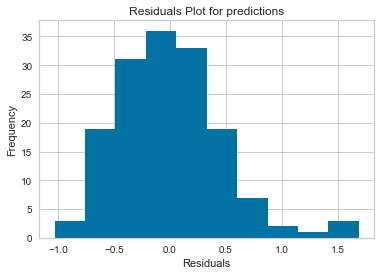

In [36]:
# Mode1 Plot
model1_plot.plot()

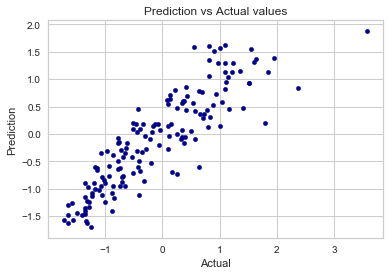

In [37]:
model1_scatter.plot()

Model 2

In [38]:
model2_plot = HistogramPlotter(y_test2, model2.predict(sm.add_constant(X_test2)))
model2_scatter = ScatterPlotter(y_test2, model2.predict(sm.add_constant(X_test2)))

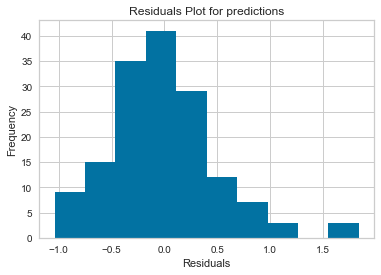

In [39]:
model2_plot.plot()

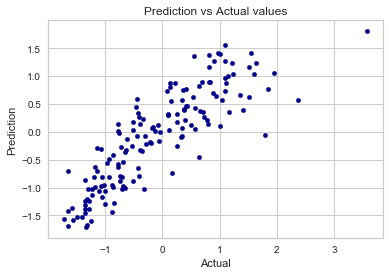

In [40]:
model2_scatter.plot()